In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
from osgeo import gdal
import dem_getter as dg #repository for functions to request/download/merge geospatial data from TNM

from mmp_classes import PeaksInImage, ImageData, MidpointIdx, PolarImage

In [2]:
my_image = 'path/to/your/image' #input .heic or .jpg image

my_image = '/Users/hankg/Downloads/IMG_8791.jpg'
image_geo_info = ImageData(my_image)

lat_orig = image_geo_info.lat
long_orig = image_geo_info.long

In [3]:
already_downloaded = True
if already_downloaded:
    file_path = "/path/to/MountainMappingProj/temp_merged_files.tif" #change path to repository
    file_path = "/Users/hankg/Desktop/MountainMappingProj/temp_merged_files.tif"
    #read data
    data_set = gdal.Open(file_path, gdal.GA_ReadOnly)

else:
    #bounding box
    lat_min = lat_orig - 1
    lat_max = lat_orig + 1
    long_min = long_orig + 1
    long_max = long_orig - 1
    
    dl_list=dg.get_aws_paths('NED_1as', long_min,lat_min,long_max,lat_max,
                             filePath = None,
                             dataType = '',
                             doExcludeRedundantData=True)
    
    #Dowload these files
    if os.path.isdir('./temp_folder') == 0:
        os.mkdir('./temp_folder')
        
    
    saved_paths = dg.batch_download(dl_list, folderName = "temp_folder")
    
    #Merge downloaded data
    data_set = dg.merge_warp_dems(saved_paths, 'temp_merged_files.tif',
                                  #outExtent = [[lat_min,lat_max],[long_min,long_max]], #Output bounding box (if you want a crop of the merged product) (can produce buggy elevations)
                                  doReturnGdalSourceResult = True, #If you want back a gdal Dataset object
                                  resampleAlg = 'cubic', #How to preform resampling when needed
                                  format = 'GTiff') #Specify a format to save
    
    #Remove temp files
    [os.remove(f) for f in saved_paths]
    os.rmdir('temp_folder')

band1 = data_set.ReadAsArray()
gt = np.asarray(data_set.GetGeoTransform())

/Users/hankg/anaconda3/envs/mmp_env/lib/python3.9/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
#GET COLORADO PEAKS COORDS
df = pd.read_csv('./colorado peaks.csv')

#get data frame with selected columns (name, lat, and long)
features = ['Feature Name', 'Latitude', 'Longitude']
df_selected = df[features]

#get lat and long in numpy format
y_g1 = df_selected['Latitude'].to_numpy()
x_g1 = df_selected['Longitude'].to_numpy()

#get peaks in DEM bounding box and pixel coordinates of photo location in DEM
aoi_P1 = PeaksInImage(data_set, x_g1, y_g1)
midpoint = MidpointIdx(data_set, image_geo_info.lat, image_geo_info.long)

In [5]:
elev_add = 20 #increasing means more (potentially falsely and potentially truely obscured) peaks, decreasing is opposite

start = time.time()
polar_image = PolarImage(band1, gt, midpoint.midpoint, image_geo_info.lat, aoi_P1.aoi_P1, aoi_P1.row_indices, elev_add, df_selected)
end = time.time()

print(f"Total time for polar image = {int(np.round(end - start))} seconds")  

Done with cart2pol in 78 seconds
Done with unwrap_peak_labels in 3 seconds
Done with filling pano image aray in 34 seconds
Done with artifact correction in 2 seconds
Total time for polar image = 118 seconds


In [17]:
#plot the panoramic rendered view
def plot_mtns(adjust=False, lab = True, cmap_col = 'cool', expanded = True, save_image = False, norm = True):
    #lab is true if you want named peaks labeled
    #expanded if you want 720 degree view (useful if photo crosses from one edge of rendered view to other)
    #norm for normalized color values
    
    plt.figure(figsize=(75, 16))
    
    #expanded view, 720 degrees, in case picture wraps (default)
    if expanded:
        imshow_arr_2 = np.tile(polar_image.art_cor_pano_image, (1,3))
        start_slice = np.floor(imshow_arr_2.shape[1]/6).astype(int)
        end_slice = np.ceil(5*imshow_arr_2.shape[1]/6).astype(int)
    
        imshow_arr_2 = imshow_arr_2[:,start_slice:end_slice]
        if norm:
            norm = plt.Normalize(vmin=imshow_arr_2.min(), vmax=imshow_arr_2.max())
            imshow_arr_2 = norm(imshow_arr_2)
            plt.imshow(imshow_arr_2, cmap = cmap_col, aspect='auto', origin = 'lower')
        else:
            plt.imshow(imshow_arr_2, cmap = cmap_col, aspect='auto', origin = 'lower')
    
        theta_adjust_middle_third = polar_image.name_peak_df_art_cor['Theta']
        theta_adjust_middle_third = theta_adjust_middle_third + start_slice
        elev_adjust_middle_third = polar_image.name_peak_df_art_cor['Elevations']
        names_sorted_middle_third = polar_image.name_peak_df_art_cor['Peak Name']
    
        theta_adjust_first_third = theta_adjust_middle_third[theta_adjust_middle_third > imshow_arr_2.shape[1]/2] - polar_image.art_cor_pano_image.shape[1]
        elev_adjust_first_third = elev_adjust_middle_third[theta_adjust_middle_third > imshow_arr_2.shape[1]/2]
        names_sorted_first_third = names_sorted_middle_third[theta_adjust_middle_third > imshow_arr_2.shape[1]/2]
        
        theta_adjust_last_third = theta_adjust_middle_third[theta_adjust_middle_third < imshow_arr_2.shape[1]/2] + polar_image.art_cor_pano_image.shape[1]
        elev_adjust_last_third = elev_adjust_middle_third[theta_adjust_middle_third < imshow_arr_2.shape[1]/2]
        names_sorted_last_third = names_sorted_middle_third[theta_adjust_middle_third < imshow_arr_2.shape[1]/2]
    
        theta_all = np.concatenate((theta_adjust_first_third, theta_adjust_middle_third, theta_adjust_last_third), axis = 0)
        elev_all = np.concatenate((elev_adjust_first_third, elev_adjust_middle_third, elev_adjust_last_third), axis = 0)
        names_all = np.concatenate((names_sorted_first_third, names_sorted_middle_third, names_sorted_last_third), axis = 0)
    
        texts = []
    
        if lab:
            plt.scatter(theta_all, elev_all, s=25, c='b')
            for x, y, s in zip(theta_all, elev_all, names_all):
                texts.append(plt.text(x, y, s, size=9, ha='center', va='center'))
    
        plt.gca().invert_xaxis()
    
            if adjust:
                adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
            
        if save_image:
            # save the image
            if lab:
                if norm:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_norm_expanded_labeled.png")
        
                else:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_expanded_labeled.png")
            else:      
                if norm:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_norm_expanded.png")
        
                else:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_expanded.png")
                
    #non expanded (360 view, but bad for image registration when photo wraps from one edge of rendered view to other)
    else:
        if norm:
            norm = plt.Normalize(vmin=polar_image.art_cor_pano_image.min(), vmax=polar_image.art_cor_pano_image.max())
            imshow_arr_2 = norm(polar_image.art_cor_pano_image)
            plt.imshow(imshow_arr_2, cmap = cmap_col, aspect='auto', origin = 'lower')
        else:
            plt.imshow(imshow_arr_2, cmap = cmap_col, aspect='auto', origin = 'lower')
    
        theta = polar_image.name_peak_df_art_cor['Theta']
        elev = polar_image.name_peak_df_art_cor['Elevations']
        names = polar_image.name_peak_df_art_cor['Peak Name']
    
        texts = []
    
        if lab:
            plt.scatter(theta, elev, s=25, c='b')
            for x, y, s in zip(theta, elev, names):
                texts.append(plt.text(x, y, s, size=9, ha='center', va='center'))
    
            if adjust:
                adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
            
    
        plt.gca().invert_xaxis()
        if save_image:
            # save the image
            if lab:
                if norm:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_norm_labeled.png")
        
                else:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_labeled.png")
            else:
                if norm:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+"_norm.png")
        
                else:
                    plt.savefig("view_from_"+str(np.round(lat_orig, decimals = 3))+image_geo_info.lat_ref+"_"+str(np.round(long_orig, decimals = 3))+image_geo_info.long_ref+"_"+cmap_col+".png")
            

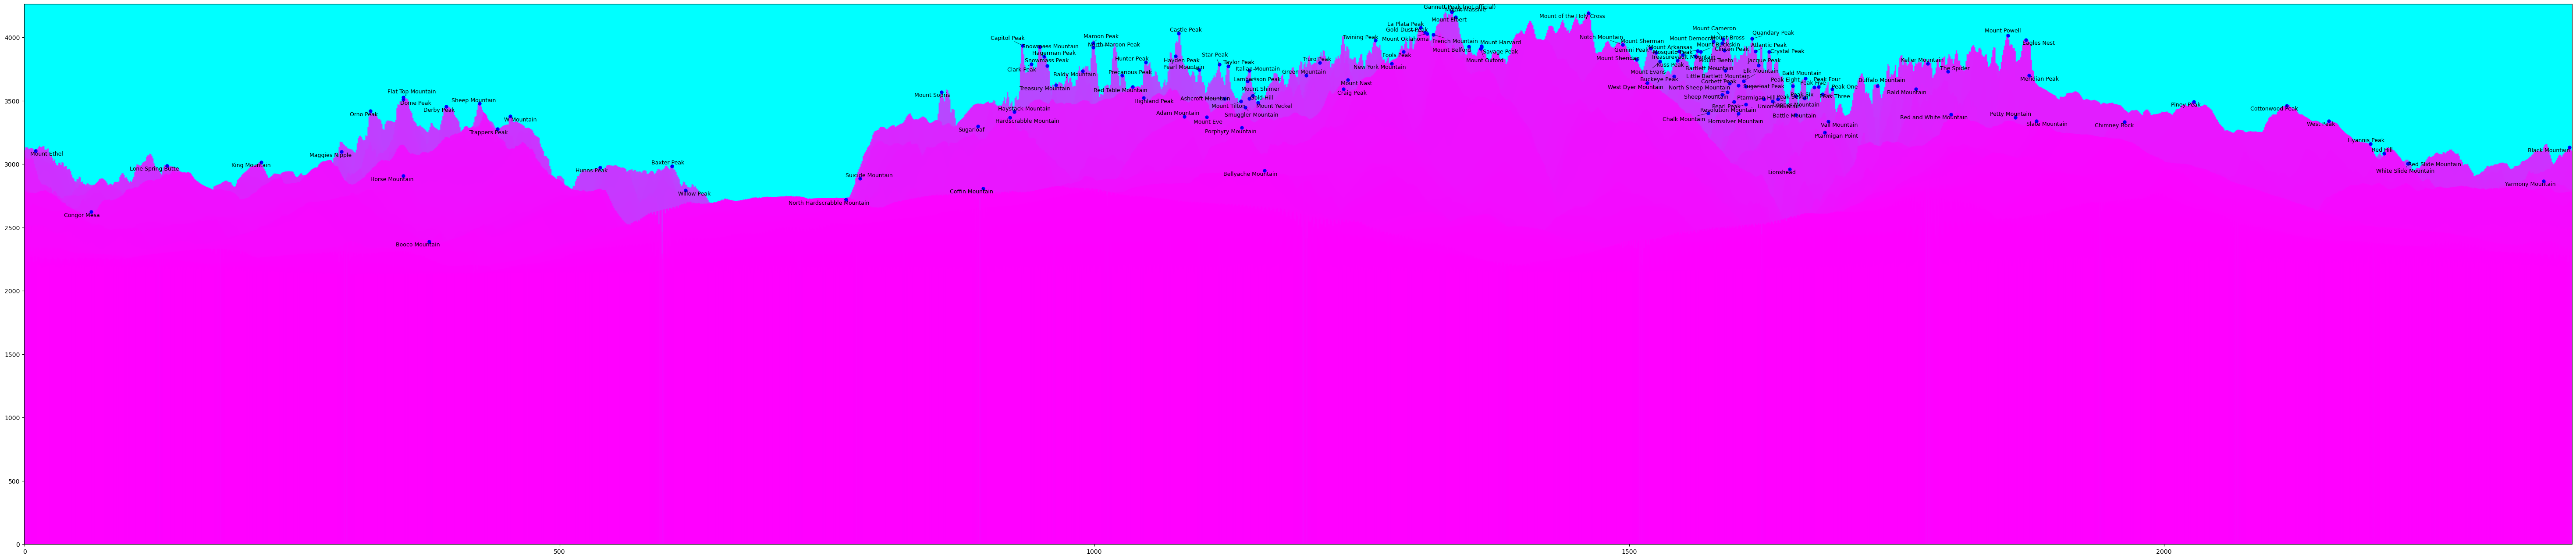

In [18]:
plot_mtns(adjust = True, lab = True, save_image = True, expanded = False)

In [10]:
#Plot DEM data 
def plot_dem(mp = True, obs_mtns = True, all_mtns = True):
    #mp true if you want to see photo location (shown in blue)
    #obs_mtns refers to mountains observable from photo location
    #all_mtns are all mountains in the DEM 
    
    if all_mtns:
        obs_mtns = False #observed mountains are in all mountains
        
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_alpha(0)
    
    dem_plot = ax.imshow(band1, cmap='terrain', aspect='auto', zorder=1, alpha = 1)
    plt.colorbar(dem_plot, ax=ax, label='Elevation')
    
    idx_mountains_image = polar_image.name_peak_df_art_cor['Mountain Index']
    
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.tight_layout()
    
    with_mp = ""
    mt_type = "no " 
    
    if mp:
        with_mp = " + image location"
        plt.scatter(midpoint.midpoint[0], midpoint.midpoint[1])
        
    if obs_mtns:
        mt_type = "observable "
        plt.scatter(aoi_P1.aoi_P1[idx_mountains_image,0], aoi_P1.aoi_P1[idx_mountains_image,1])
        
    if all_mtns:
        mt_type = "all "
        plt.scatter(aoi_P1.aoi_P1[:,0], aoi_P1.aoi_P1[:,1])

    plt.title("DEM and " + mt_type + "mountains" + with_mp + " in DEM")
    plt.show()


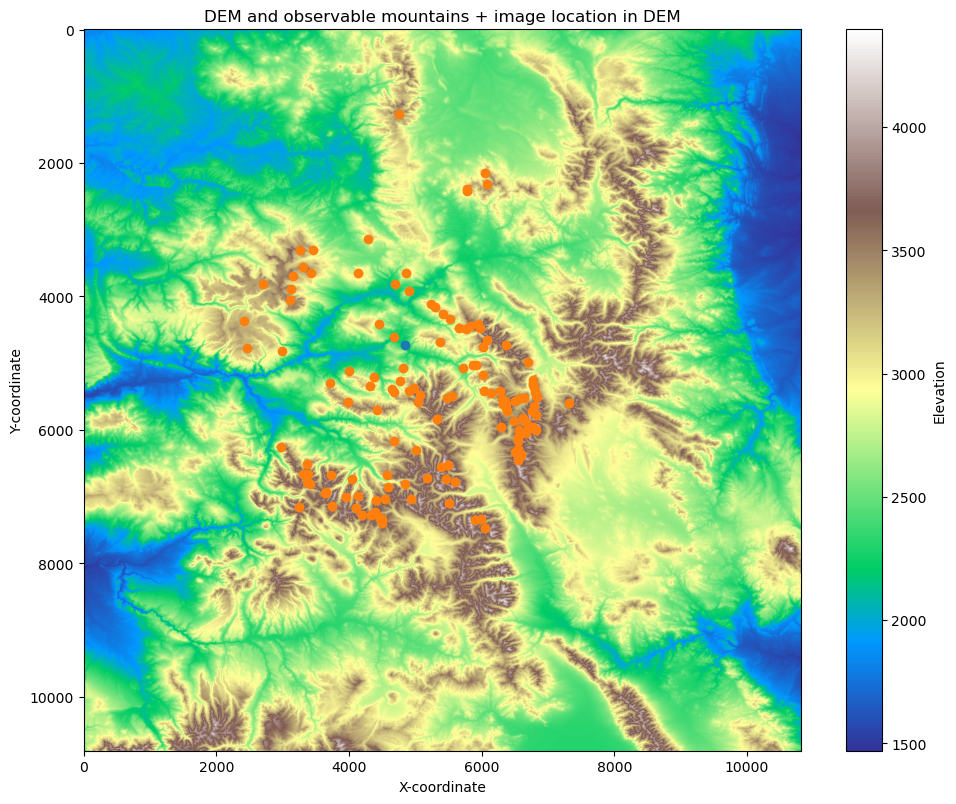

In [11]:
plot_dem(all_mtns = False)